# Constant Distance Simulation Post Plotting Scripts
Combines data from output files used for plotting.
Contact maps, bond cosines, and energy components
Saves all plotted data to files be used for making plots readily from plotted data later.

In [1]:
import sys
import numpy as np
import scipy as sc
import os
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import randint
from array import *
import fileinput
import itertools
import linecache
from itertools import islice
from scipy.spatial import distance
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#Don't show figures, only save:
#mpl.use('Agg')

if not os.path.exists('VisPlots'):
    os.makedirs('VisPlots')
    
if not os.path.exists('VisPlots/ContactMaps'):
    os.makedirs('VisPlots/ContactMaps')
    
if not os.path.exists('VisPlots/DiffMaps'):
    os.makedirs('VisPlots/DiffMaps')

#xAxisMode = 'dist'    
xAxisMode = 'strain'

#xAxisIndex picks either x-axis numbers from a list containing both strain values and raw distances.
if xAxisMode == 'dist':
    xAxisIndex=0
elif xAxisMode == 'strain':
    xAxisIndex=1

In [2]:
plt.rcParams.update({'font.size': 12, 'figure.figsize': [2, 2]})

#Standard Figure Width and Height
w=2
h=2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
# Variables:
kpull=10000
numBeads = 738
numReps = 40
jobName = 'CD15m'
Time_Label = '15m'
eqBlocks = 0 #Number of simulation blocks to skip before recording pull coordinate for histograms.

distnum = 190
distjump = 0.1
timestep=.01
blockSize = 5
d0=10

breakNum = 152 #Distnum at which unraveling regime begins

VisPlotsJump = 50 #In units of distjump, distance between replicas shown in comparison plots.

PlotStrainJump = 0.2
PlotStrainStart = -0.2
PlotStrainEnd = 1
PlotStrains = np.arange(PlotStrainStart, PlotStrainEnd+PlotStrainJump, PlotStrainJump)


dt = timestep*blockSize
dists = np.arange(d0,d0+distnum*distjump+distjump, distjump)

def makeEnerFName(distnum):
    return 'MeanEner_' + str(curdistnum) + '.dat'

def makeContMapFName(distnum):
    return 'Prob_' + str(curdistnum) + '.dat'

def makeCosFName(distnum):
    return 'CosDict_'+str(curdistnum)+'.txt'

def makeMSDFName(distnum):
    return 'CD_'+str(curdistnum)+'_MSD.txt'
    
def makePullCoordFName(distnum):
    return 'CD_'+str(curdistnum)+'_Pull_Coord.txt'

def makeSingleJobName(distnum):
    return 'CD15m_'+str(curdistnum)

In [5]:
#List of Colors:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

# Energy and PMF:

First computes PMF and Native Length

In [6]:
FExt_Data=np.genfromtxt('PlotData/'+jobName+'-FExtDat.dat',dtype='f8', delimiter=' ')
dists = FExt_Data[0,:]
MeanForces=FExt_Data[1,:]
StdForces=FExt_Data[2,:]
SEMForces=FExt_Data[3,:]

PMF=[]
curPMF=0
PMF.append(curPMF)

for i in range(1, len(dists)):
    xcur = dists[i]
    fcur = (MeanForces[i-1]+MeanForces[i])/2
    curPMF+=distjump*fcur
    PMF.append(curPMF)
    
PMF = np.array(PMF)
PMF = PMF-np.min(PMF)

natIndex = np.argmin(PMF)

natlen=round(dists[np.argmin(PMF)],2)
natStrain=0

print(natlen)

13.2


In [7]:
#Makes list of Strains given dists and natlen:

strains = (dists-natlen)/natlen
    
strains = np.array(strains)

PlotIndices = []
for curStrain in PlotStrains:
    PlotIndices.append(np.argmin(np.abs(strains-curStrain)))

xAxisNums = []
natNum = 0
xlabel = ''
if xAxisIndex==0:
    xAxisNums=dists
    natNum = natlen
    xlabel = r"Extension ($\sigma$)"
elif xAxisIndex==1:
    xAxisNums=strains
    natNum=0
    xlabel = 'Strain'

PE components

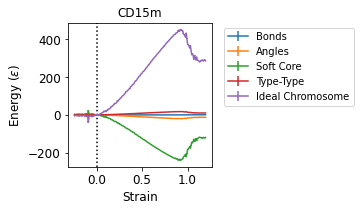

In [8]:
%matplotlib inline
MeanEnergies_AllDists = []
StdEnergies_AllDists = []

for curdistnum in range(distnum+1):
    
    singlejobname = makeSingleJobName(curdistnum)
    file = open('PlotData/'+singlejobname+'-MeanEnergies-AllReps.dat', 'r')
    lines = file.readlines()
    MeanEnergies = [float(num) for num in lines[1].strip().split()]
    StdEnergies = [float(num) for num in lines[2].strip().split()]
    MeanEnergies_AllDists.append(MeanEnergies)
    StdEnergies_AllDists.append(StdEnergies)

MeanEnergies_AllDists = np.matrix(MeanEnergies_AllDists)
StdEnergies_AllDists = np.matrix(StdEnergies_AllDists)
fig, ax = plt.subplots(figsize = (5,4))

EnergyComponents = ['Bonds', 'Angles', 'Soft Core', 'Type-Type', 'Ideal Chromosome']

minIndex = np.argmin(np.abs(dists-natlen))#Index of Native Length Entries.

TotalPE = 0*(np.array((MeanEnergies_AllDists[:,0]-MeanEnergies_AllDists[minIndex,0]).T)[0])#Starts as 0.  Stores total PE.

for index, curcomp in enumerate(EnergyComponents):
    curenergies = (np.array((MeanEnergies_AllDists[:,index]-MeanEnergies_AllDists[minIndex,index]).T)[0])
    TotalPE+=curenergies
    curstds = ((np.array(StdEnergies_AllDists[:,index])).T)[0]
    cursems = np.divide(curstds, numReps)
    ax.errorbar(xAxisNums, curenergies, yerr = cursems, label = curcomp, capsize=0)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.axvline(x=natNum, ls=':', color='black')
ax.set_ylabel(r"Energy ($\epsilon$)")
ax.set_xlabel(xlabel)
ax.set_title(jobName)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.legend(loc='upper left')

#fig.show()
#fig.tight_layout()
set_size(w,h,ax)
fig = plt.gcf()
fig.savefig('VisPlots/Energies_'+jobName+'.pdf', dpi = 300, bbox_inches='tight')

# PMF (From Integrating Force Extension Curve) VS. Total Potential Energy

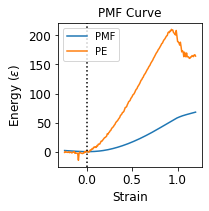

In [9]:
fig, ax = plt.subplots()
#ax.errorbar(dists, MeanForces, yerr = SEMForces, ls='None', elinewidth=2, capsize=1, capthick=2)
ax.plot(xAxisNums, PMF, label='PMF')
ax.plot(xAxisNums, TotalPE, label = 'PE')
ax.axvline(x=natNum, ls=':', color='black')
ax.set_xlabel(xlabel)
ax.set_ylabel(r'Energy ($\epsilon$)')
ax.set_title('PMF Curve')
ax.legend(loc='upper left')
#fig.tight_layout()
set_size(w,h,ax)
fig.savefig('VisPlots/PMF_'+jobName+'.pdf', bbox_inches='tight')

Calculates Entropy change associated with the reaction coordinate using $\Delta G = \Delta U - T \Delta S$

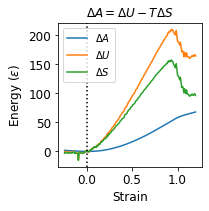

In [10]:
Entropy = TotalPE-PMF
fig,ax=plt.subplots()
ax.plot(xAxisNums, PMF, label=r'$\Delta A$')
ax.plot(xAxisNums, TotalPE, label = r'$\Delta U$')
ax.plot(xAxisNums, Entropy, label = r'$\Delta S$ ')
ax.axvline(x=natNum, ls=':', color='black')
ax.set_xlabel(xlabel)
ax.set_ylabel(r'Energy ($\epsilon$)')
ax.set_title(r'$\Delta A = \Delta U - T \Delta S$')
ax.legend(loc='upper left')

set_size(w,h,ax)
fig.savefig('VisPlots/PEGS_'+jobName+'.pdf', dpi=300, bbox_inches='tight')

# Mean Force Extension Curve:
Plots Mean and SEM of force at each extension and saves data to text file.

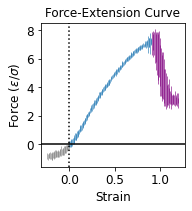

In [11]:
# Linear Regression of Force Extension Curve:
# x = np.array(dists).reshape((-1,1))
# y=np.array(MeanForces)
# model = LinearRegression()
# model.fit(x,y)
# r_sq = model.score(x,y)
# intercept = model.intercept_
# slope = float(model.coef_)

# print('Y-Intercept: ',intercept)
# print('Slope: ', slope)
# print('r squared: ', r_sq)
# NatLen = float(-intercept/slope)
# print('Native Length: ', NatLen)

CFColors = ['gray', '#1f77b4', 'purple']    
fig, ax = plt.subplots()
ax.errorbar(xAxisNums[0:natIndex], MeanForces[0:natIndex], yerr = StdForces[0:natIndex], ls='None', elinewidth=.6, color = CFColors[0])
ax.errorbar(xAxisNums[natIndex:breakNum], MeanForces[natIndex:breakNum], yerr = StdForces[natIndex:breakNum], ls='None', elinewidth=.6, color = CFColors[1], markersize = 1)
ax.errorbar(xAxisNums[breakNum:], MeanForces[breakNum:], yerr = StdForces[breakNum:], ls='None', elinewidth=.6, color = CFColors[2])

# ax.plot(dists, np.multiply(slope,dists)+intercept, ls = ':', color = 'r')
ax.set_xlabel(xlabel)
ax.set_ylabel(r'Force ($\epsilon/\sigma$)')
ax.set_title('Force-Extension Curve')
ax.axhline(y=0, color='black')
ax.axvline(x=natNum, ls=':', color='black')

# NatLenRounded = float(round(10*NatLen))/10
# SlopeRounded = float(round(100*slope))/100
# r_rounded = float(round(1000*r_sq))/1000
#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()

# ax.text(left+.1, top-.2, s='X-Int: ' + str(NatLenRounded)+r" $\sigma$", ha='left', va='top')
# ax.text(left+.1, top-.9, s='Slope: ' + str(SlopeRounded) + r" $\epsilon/\sigma^2$", ha='left', va='top')
# ax.text(left+.1, top-1.6, s=r'$r^2$: ' + str(r_rounded), ha='left', va='top')
set_size(w,h,ax)
fig.savefig('VisPlots/FExt_'+jobName+'.pdf', bbox_inches='tight')

## Compare force extension curve to constant-force simulation force-extension curve

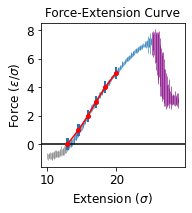

In [12]:
fig, ax = plt.subplots()
ax.errorbar(dists[0:natIndex], MeanForces[0:natIndex], yerr = StdForces[0:natIndex], ls='None', elinewidth=.6, color = CFColors[0])
ax.errorbar(dists[natIndex:breakNum], MeanForces[natIndex:breakNum], yerr = StdForces[natIndex:breakNum], ls='None', elinewidth=.6, color = CFColors[1], markersize = 1)
ax.errorbar(dists[breakNum:], MeanForces[breakNum:], yerr = StdForces[breakNum:], ls='None', elinewidth=.6, color = CFColors[2])
# ax.plot(dists, np.multiply(slope,dists)+intercept, ls = ':', color = 'r')
ax.set_xlabel(r'Extension ($\sigma$)')
ax.set_ylabel(r'Force ($\epsilon/\sigma$)')
ax.set_title('Force-Extension Curve')
ax.axhline(y=0, color='black')

#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()

FExt_Data_CF=np.genfromtxt('../CFSim-15m/PlotData/CF15m-FExtDat.dat',dtype='f8', delimiter=' ')

Forces_CF = FExt_Data_CF[0,:]
MeanExtensions_CF = FExt_Data_CF[1,:]
StdExtensions_CF = FExt_Data_CF[2,:]
SEMExtensions_CF = FExt_Data_CF[3,:]

ax.errorbar(MeanExtensions_CF, Forces_CF, xerr = SEMExtensions_CF, ls='None', elinewidth=2, capsize=6, capthick=2)
ax.plot(MeanExtensions_CF, Forces_CF, ls='-', c = 'r', marker = 'o', markersize=4)
#ax.plot(MeanExtensions, np.multiply(slope,MeanExtensions)+intercept, ls = ':', color = 'r')
#ax.plot(MLExts, forces, ls='None', color='black', marker='x')
set_size(w,h,ax)
fig.savefig('VisPlots/FExt_CompCDCF'+jobName+'.pdf', bbox_inches='tight')

## Compare force extension curve to constant-force simulation ML Exts.

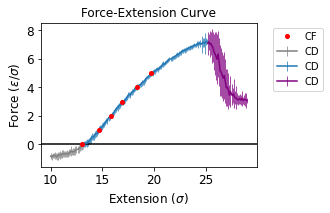

In [13]:
fig, ax = plt.subplots()
elw = .7
ax.errorbar(dists[0:natIndex], MeanForces[0:natIndex], yerr = StdForces[0:natIndex], ls='-', elinewidth=elw, color = CFColors[0], label='CD')
ax.errorbar(dists[natIndex:breakNum], MeanForces[natIndex:breakNum], yerr = StdForces[natIndex:breakNum], ls='-', elinewidth=elw, color = CFColors[1], label='CD')
ax.errorbar(dists[breakNum:], MeanForces[breakNum:], yerr = StdForces[breakNum:], ls='-', elinewidth=elw, color = CFColors[2], label='CD')
# ax.plot(dists, np.multiply(slope,dists)+intercept, ls = ':', color = 'r')
ax.set_xlabel(r'Extension ($\sigma$)')
ax.set_ylabel(r'Force ($\epsilon/\sigma$)')
ax.set_title('Force-Extension Curve')
ax.axhline(y=0, color='black')

#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()

FExt_Data_CFMLExt=np.genfromtxt('../CFSim-15m/PlotData/MLExts.txt',dtype='f8', delimiter=' ')

Forces_CF = FExt_Data_CF[0,:]

ax.plot(FExt_Data_CFMLExt, Forces_CF, ls='none', c = 'r', marker = 'o', markersize=4, label = 'CF', zorder = 10)
#ax.plot(MeanExtensions, np.multiply(slope,MeanExtensions)+intercept, ls = ':', color = 'r')
#ax.plot(MLExts, forces, ls='None', color='black', marker='x')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([10, 15, 20, 25])
set_size(3,2,ax)
fig.savefig('VisPlots/FExt_CompCDCF'+jobName+'.pdf', bbox_inches='tight')

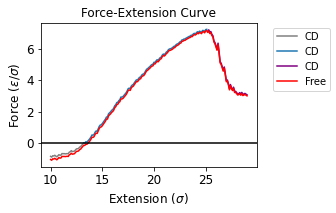

In [14]:
#Now include the caclulated free-ends force extension curve.

fig, ax = plt.subplots()
elw = .7
ax.plot(dists[0:natIndex], MeanForces[0:natIndex], ls='-', color = CFColors[0], label='CD')
ax.plot(dists[natIndex:breakNum], MeanForces[natIndex:breakNum], ls='-', color = CFColors[1], label='CD')
ax.plot(dists[breakNum:], MeanForces[breakNum:], ls='-', color = CFColors[2], label='CD')

FreeForces = np.subtract(MeanForces, np.divide(2, dists))
ax.plot(dists, FreeForces, ls='-', color = 'red', label = 'Free')
# ax.plot(dists, np.multiply(slope,dists)+intercept, ls = ':', color = 'r')
ax.set_xlabel(r'Extension ($\sigma$)')
ax.set_ylabel(r'Force ($\epsilon/\sigma$)')
ax.set_title('Force-Extension Curve')
ax.axhline(y=0, color='black')

#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()

FExt_Data_CFMLExt=np.genfromtxt('../CFSim-15m/PlotData/MLExts.txt',dtype='f8', delimiter=' ')

Forces_CF = FExt_Data_CF[0,:]

#ax.plot(FExt_Data_CFMLExt, Forces_CF, ls='none', c = 'r', marker = 'o', markersize=4, label = 'CF', zorder = 10)
#ax.plot(MeanExtensions, np.multiply(slope,MeanExtensions)+intercept, ls = ':', color = 'r')
#ax.plot(MLExts, forces, ls='None', color='black', marker='x')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([10, 15, 20, 25])
set_size(3,2,ax)
fig.savefig('VisPlots/FExt_Free'+jobName+'.pdf', bbox_inches='tight')

In [15]:
print(Forces_CF)

[0. 1. 2. 3. 4. 5.]


In [16]:
for i in range(25,45):
    print('Dist: '+str(dists[i]) + ' Force: ' + str(MeanForces[i]))

Dist: 12.499999999999991 Force: -0.37006653689886093
Dist: 12.59999999999999 Force: -0.36277324895195306
Dist: 12.69999999999999 Force: -0.34595543676019247
Dist: 12.79999999999999 Force: -0.2612541119795253
Dist: 12.89999999999999 Force: -0.23295933679889913
Dist: 12.99999999999999 Force: -0.1464322786404182
Dist: 13.099999999999989 Force: -0.07378607691066463
Dist: 13.199999999999989 Force: 0.005044878257365326
Dist: 13.299999999999988 Force: -0.004068079544339298
Dist: 13.399999999999988 Force: 0.0792277963057586
Dist: 13.499999999999988 Force: 0.06449696552834894
Dist: 13.599999999999987 Force: 0.12670034378103878
Dist: 13.699999999999987 Force: 0.19876374151905907
Dist: 13.799999999999986 Force: 0.27990282809753353
Dist: 13.899999999999986 Force: 0.38220868233906913
Dist: 13.999999999999986 Force: 0.5117418381317407
Dist: 14.099999999999985 Force: 0.49996999058166125
Dist: 14.199999999999985 Force: 0.5441314999821145
Dist: 14.299999999999985 Force: 0.6888942094995798
Dist: 14.3999

Derivative of the force-extension curve:  Look for nonlinear stiffening exponent

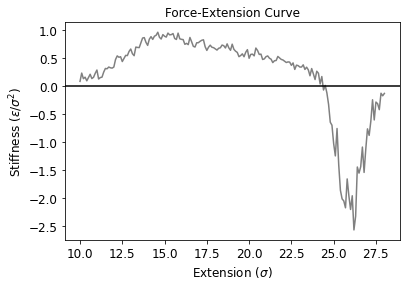

In [17]:
fig, ax = plt.subplots()
window = 10
Stiffnesses = 1/(distjump*window)*(MeanForces[window:]-MeanForces[:-window])
ax.plot(dists[:-window], Stiffnesses, ls='-', color = CFColors[0])

ax.set_xlabel(r'Extension ($\sigma$)')
ax.set_ylabel(r'Stiffness ($\epsilon/\sigma^2$)')
ax.set_title('Force-Extension Curve')
ax.axhline(y=0, color='black')

#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()

## Reaction Coordinate Histograms

In [18]:
BinWidth=.001
f = open('PlotData/'+jobName+"HistData.txt","r")
lines = f.readlines()
relativeEdges = [float(num) for num in lines[0].strip().split()]
relativeCenters = np.divide(np.add(relativeEdges[:-1],relativeEdges[1:]),2)


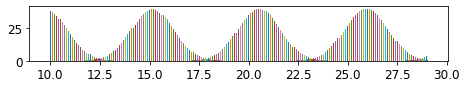

In [19]:
fig, ax = plt.subplots(figsize=(7.5,1))
for curdistnum in range(distnum+1):
    Centers = np.add(relativeCenters, dists[curdistnum])
    curBinValues = [float(num) for num in lines[curdistnum+1].strip().split()]
    ax.bar(Centers, curBinValues, width=BinWidth)
#fig.text(0.5, 0, r"End to End Distance ($\sigma$)", ha='center')
#fig.text(-.05, 0.5, r"Probability Density", va='center', rotation='vertical')

fig = plt.gcf()
fig.savefig('VisPlots/Hists_'+jobName+'.pdf', bbox_inches='tight')    
#plt.close(fig)

In [20]:
def gaussian(x, sigma,mu): return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-1/(2*sigma**2)*(x-mu)**2)

 Mean = 19.99948560451266
Var = 0.01000632129188028


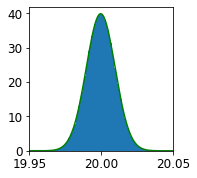

In [21]:
# Plot a single reaction coordinate histogram
curdistnum = 100

Centers = np.add(relativeCenters, dists[curdistnum])
curBinValues = [float(num) for num in lines[curdistnum+1].strip().split()]

pars, cov = curve_fit(f=gaussian, xdata = Centers, ydata = curBinValues, p0=[.02, dists[curdistnum]])
var = pars[0]
mean = pars[1]
print(' Mean = ' + str(mean))
print('Var = ' + str(var))

fig, ax = plt.subplots()
ax.bar(Centers, curBinValues, width=BinWidth)
ax.set_xlim([dists[curdistnum]-.05, dists[curdistnum]+.05])
ax.plot(Centers, gaussian(Centers, var, mean), color = 'green')
set_size(w,h,ax)
fig = plt.gcf()
fig.savefig('VisPlots/SingleHist_'+jobName+'.pdf', bbox_inches='tight')  

In [22]:
kp = 10000
var_expected = np.sqrt(1/kp) 
print('Standard Deviation Expected: ' + str(var_expected))

mean_expected = dists[curdistnum] - 1/kp*MeanForces[curdistnum]
print('Expected Mean: ' + str(mean_expected))

Standard Deviation Expected: 0.01
Expected Mean: 19.999487062129795


### Parts of Force by PE components

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

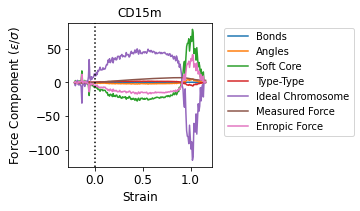

In [24]:
windowSize = 10
PE_Smooth = [moving_average((MeanEnergies_AllDists[:,i]).reshape(1,-1).tolist()[0], windowSize) for i in range(len(np.transpose(MeanEnergies_AllDists)))]
smoothXNums = moving_average(xAxisNums, windowSize).tolist()[:-1]
fig, ax = plt.subplots(figsize = (8,4))

for index, curcomp in enumerate(EnergyComponents):
    curPESmooth = PE_Smooth[index]
    curForce = (curPESmooth[1:]-curPESmooth[:-1])/distjump
    ax.plot(smoothXNums, curForce, label = curcomp)
    
smooth_true_force = moving_average(MeanForces, windowSize)

ax.plot(smoothXNums,  smooth_true_force[:-1], label = 'Measured Force')

smooth_entropy = moving_average(Entropy, windowSize)
entropicForce = -(smooth_entropy[1:]-smooth_entropy[:-1])/distjump

ax.plot(smoothXNums, entropicForce, label = 'Enropic Force')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.axvline(x=natNum, ls=':', color='black')
ax.set_ylabel(r"Force Component ($\epsilon/\sigma$)")
ax.set_xlabel(xlabel)
ax.set_title(jobName)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.legend(loc='lower left')

#fig.show()
fig = plt.gcf()
set_size(w,h,ax)
fig.savefig('VisPlots/ForceComps_'+jobName+'.pdf', dpi = 300, bbox_inches='tight')

# Bond Cosines Under Strain

In [25]:
# importing the module 
import ast 
AllMeanCosDicts = [] #List of Mean Cosine Dictionaries.

for curdistnum in range(distnum+1):
    
    singlejobname = makeSingleJobName(curdistnum)

    ## Open MeanCosDict Here
    curfile = 'PlotData/'+singlejobname+'MeanCosDict.txt'
    with open(curfile) as f: 
        data = f.read() 
        #print("Data type before reconstruction: ", type(data)) 
        # reconstructing the data as a dictionary 
        d = ast.literal_eval(data) 
        #print("Data type after reconstruction : ", type(d)) 
        #print(d)
        AllMeanCosDicts.append(d)

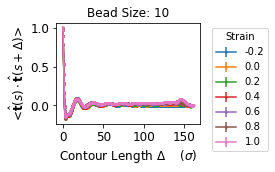

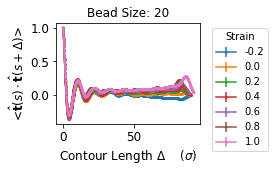

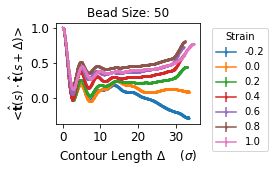

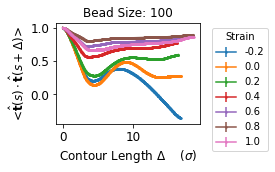

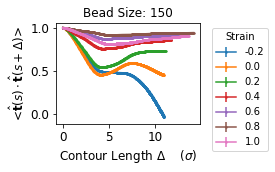

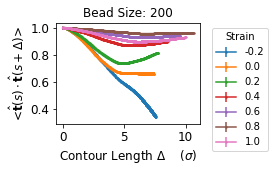

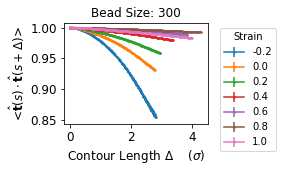

In [26]:
n_arr = list(AllMeanCosDicts[0].keys())

colorind=0
for i,n in enumerate(n_arr, start = 0):

    fig, ax = plt.subplots()
    ax.set_title('Bead Size: '+ str(n))

    colorind=0
    for index, curNum in enumerate(xAxisNums):
        if index in PlotIndices:
            MeanCosDict = AllMeanCosDicts[index]
            ax.errorbar(x=MeanCosDict[n]['len'], y=MeanCosDict[n]['cos'], yerr = MeanCosDict[n]['stdcos']/np.sqrt(numReps), label = round(curNum+.001,2), c = colors[colorind], marker = 'o', markersize=1.4)
            #ax.plot(MeanCosDict[n]['len'], MeanCosDict[n]['cos'], label = round(curNum,1), c = colors[colorind], marker = 'o', markersize=2)
            colorind+=1
        
    #ax.axhline(y=0, ls=':', color='black')
    ax.set_xlabel(r"Contour Length $\Delta$    ($\sigma$)")
    ax.set_ylabel(r"<$\hat{\mathbf{t}}(s)\cdot \hat{\mathbf{t}}(s+\Delta)$>")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=xlabel)
    set_size(2,1.75*4/5,ax)
    fig.savefig('VisPlots/AllCosines_'+jobName+'_'+str(n)+'.pdf', dpi = 300, bbox_inches='tight')
#plt.close(fig)

# Radius of Gyration of CG Beads

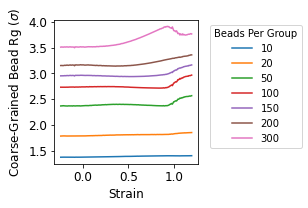

In [27]:
# Plot Rgs:
fig, ax = plt.subplots()    
    
for i,n in enumerate(n_arr, start = 0):
    RG_list = []
    for index, xAxisNum in enumerate(xAxisNums):
        RG_list.append(AllMeanCosDicts[index][n]['rg'])
    
    ax.plot(xAxisNums, RG_list, label = str(n))#, marker = 'o')

ax.set_xlabel(xlabel)
ax.set_ylabel(r'Coarse-Grained Bead Rg $(\sigma)$')
ax.legend(title = 'Beads Per Group', bbox_to_anchor=(1.05, 1), loc='upper left')
fig = plt.gcf()
set_size(w,h,ax)
fig.savefig('VisPlots/RGs_'+jobName+'.pdf', dpi = 300, bbox_inches='tight')

# Compacton Under Strain

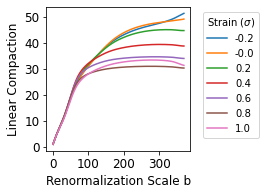

In [28]:
BondLen_Data=np.genfromtxt('PlotData/' + jobName+'-AllBondLens.dat',dtype='f8', delimiter=' ')

fig, ax = plt.subplots()

LL = len(BondLen_Data[0])
beadSizes = range(1, LL+1)
effSingleBondLens = np.divide(BondLen_Data, beadSizes)

for colorind, curdistnum in enumerate(PlotIndices):
    
    Compaction=np.divide(effSingleBondLens[curdistnum,0], effSingleBondLens[curdistnum,:])
    ax.plot(range(1, LL+1), Compaction, label=str(round(xAxisNums[curdistnum],1)), c = colors[colorind])
    
ax.set_xlabel(r"Renormalization Scale b")
ax.set_xticks([0, 100, 200, 300])
ax.set_ylabel('Linear Compaction')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"Strain ($\sigma$)")
fig = plt.gcf()
set_size(w,h,ax)
fig.savefig('VisPlots/Compaction_'+jobName+'.pdf', bbox_inches='tight') 

# Contact Map and P vs D:

KeyboardInterrupt: 

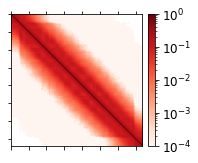

In [29]:
#Contact Maps:
AllProbs = []
for curdistnum in range(distnum+1):
    
    contMapFName = makeContMapFName(curdistnum)
    singlejobname = makeSingleJobName(curdistnum)
    l=numBeads

    r=np.genfromtxt('PlotData/'+singlejobname+'-Dist-all.dat',dtype='f8', delimiter=' ')
    fig, ax = plt.subplots()
    pos=ax.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=1),cmap="Reds")
    fig.colorbar(pos, ax = ax, fraction=0.046, pad=0.04)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    #fig = plt.gcf()
    set_size(w,h,ax)
    fig.savefig('VisPlots/ContactMaps/ContMap_'+singlejobname+'.pdf', dpi = 300, bbox_inches='tight')
    plt.close(fig)

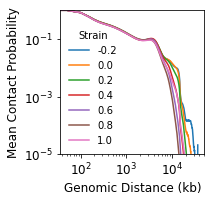

In [43]:
# Save and plot all P vs D curves:    
PvD_data=np.genfromtxt('PlotData/' + jobName+'-PvD-all.dat',dtype='f8', delimiter=' ')
fig, ax = plt.subplots()

colorind=0
for curdistnum in range(distnum+1):
    if curdistnum in PlotIndices:
        ax.plot(50*PvD_data[0,:],PvD_data[curdistnum+1,:], label=str(round(xAxisNums[curdistnum]+.001,2)), c = colors[colorind])
        colorind+=1

ax.set_xlabel(r"Genomic Distance (kb)")
ax.set_ylabel('Mean Contact Probability')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10**-5, 1)
ax.legend(title=xlabel, loc = 'lower left', frameon=False)
set_size(w,h,ax)
fig.savefig('VisPlots/AllPvD_'+jobName+'.pdf', bbox_inches='tight')

# Hi-C Difference Maps

In [ ]:
#Contact Maps:
AllProbs = []

NativeFName = 'NativePlotData/Native15m-Dist-all.dat'
NativeMap = np.genfromtxt(NativeFName,dtype='f8', delimiter=' ')

for curdistnum in range(distnum+1):
    filename = 'CD15m_'+str(curdistnum)+'-Dist-all.dat'
    r=np.genfromtxt('PlotData/'+filename,dtype='f8', delimiter=' ')
    sys.stdout.flush()

    #LogRatioMap = np.log2(r+tiny)-np.log2(NativeMap+tiny)
    diffMap = r-NativeMap
    fig, ax = plt.subplots()
    #cax = ax.matshow(diffMap,cmap='seismic')
    cax = ax.matshow(diffMap,norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=0.2, vmin=-.1, vmax=.1, base=10),cmap='PRGn')
    fig.colorbar(cax, ax = ax, fraction=0.046, pad=0.04)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    #fig.show()
    set_size(w,h,ax)
    fig.savefig('VisPlots/DiffMaps/DiffMap_15m_'+str(curdistnum)+'.pdf', dpi = 300, bbox_inches='tight')
    plt.close(fig)
    


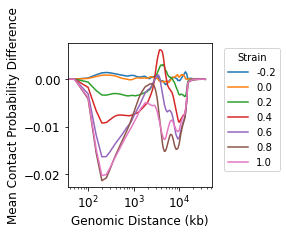

In [41]:
fig, ax = plt.subplots()

PvD_data=np.genfromtxt('PlotData/' + jobName+'-PvD-all.dat',dtype='f8', delimiter=' ')
PvD_data_Native=np.genfromtxt('NativePlotData/Native15m-PvD-all.dat',dtype='f8', delimiter=' ')

colorind=0
for curdistnum, curNum in enumerate(xAxisNums):
    if curdistnum in PlotIndices:
        ax.plot(50*PvD_data_Native[0,:],np.subtract(PvD_data[curdistnum+1,:], PvD_data_Native[1, :]), label=str(round(curNum+.001,1)), c = colors[colorind])
        colorind+=1
    
ax.set_xlabel(r"Genomic Distance (kb)")
ax.set_ylabel('Mean Contact Probability Difference')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=xlabel)
fig = plt.gcf()
set_size(w,h,ax)
fig.savefig('VisPlots/AllPvD_Diff_'+jobName+'.pdf', bbox_inches='tight') 

# Radius-Extension Curve

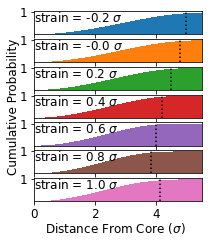

In [292]:
BinWidth = .01
maxDist = 5.5

f = open('PlotData/'+jobName+"-RadHist-Allreps.dat","r")
lines = f.readlines()
Bins = [float(num) for num in lines[0].strip().split()]
Centers = .5*np.add(Bins[1:],Bins[0:len(Bins)-1])

maxIndexHist = np.sum([cent<=maxDist for cent in Centers])

Radii = []

f, axs = plt.subplots(
        nrows=len(PlotIndices), 
        ncols=1,
        sharex=True, 
        sharey=True,
        figsize=(3,.5*len(n_arr)),
    )

colorind=0
for curdistnum, curNum in enumerate(xAxisNums):
        
    BinVals = [float(num) for num in lines[curdistnum+1].strip().split()]
    CumBinVals = np.multiply(BinWidth, np.cumsum(BinVals))
    radius = Centers[np.argmin(np.abs(CumBinVals-.95))]
    Radii.append(radius)

    if curdistnum in PlotIndices:
        
        ax = axs[colorind]
        ax.bar(Centers[:maxIndexHist], CumBinVals[:maxIndexHist], width=BinWidth, color=colors[colorind])
        colorind+=1
        ax.set_xlim(0, maxDist)
        ax.axvline(x=radius, color='black', linestyle=':')
        ax.set_yticks([1])
    
for colorind, curdistnum in enumerate(PlotIndices):
    ax = axs[colorind]
    xNum = xAxisNums[curdistnum]
    radius = Radii[curdistnum]
    bot, top = ax.get_ylim()
    ax.text(0,top,xAxisMode+' = ' + str(round(xNum,2))+r' $\sigma$', ha='left', va = 'top')
    #ax.text(0,top-.3,'R = ' + str(round(radius,2))+r' $\sigma$', ha='left', va = 'top')
       
f.text(0.5, 0, r"Distance From Core ($\sigma$)", ha='center')
f.text(0, 0.5, r"Cumulative Probability", va='center', rotation='vertical')
 
fig = plt.gcf()
fig.savefig('VisPlots/CumRadHists_'+jobName+'.pdf', bbox_inches='tight')

In [290]:
#Linear Regression of Radius vs Extension Curve:
minStrain=0
maxStrain=.4

minIndex = np.argmin(np.abs(strains-minStrain))
maxIndex = np.argmin(np.abs(strains-maxStrain))

x = np.array(strains[minIndex:maxIndex]).reshape((-1,1))
y=np.array(Radii[minIndex:maxIndex]/Radii[minIndex]-1)
model = LinearRegression()
model.fit(x,y)
r_sq = model.score(x,y)
intercept = model.intercept_
slope = float(model.coef_)

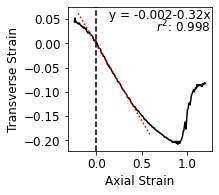

In [291]:
fig, ax = plt.subplots()
linDomain = np.linspace(-.2, .6, 10).reshape((-1,1))
ax.plot(strains, Radii/Radii[minIndex]-1, color = 'k')
ax.plot(linDomain, model.predict(linDomain), ls = ':', color = 'r')
ax.set_xlabel(r'Axial Strain')
ax.set_ylabel(r'Transverse Strain')

SlopeRounded = round(slope,2)
rsq_rounded = round(r_sq,3)
intercept_rounded = round(intercept, 3)

#Display Slope and Native Length on Plot:
left, right = ax.get_xlim()  # return the current xlim
bottom, top = ax.get_ylim()
height = top-bottom
width = right-left


ax.text(right-.01*width, top-.01*height, s='y = ' + str(intercept_rounded)+ str(SlopeRounded)+'x', ha='right', va='top')#+ r" $\epsilon/\sigma^2$")
ax.text(right-.01*width, top-.08*height, s=r'$r^2$: ' + str(rsq_rounded), ha='right', va='top')

ax.axvline(x=0, ls='--', color = 'black')
fig = plt.gcf()
set_size(w,h,ax)
fig.savefig('VisPlots/RadExt_'+jobName+'.pdf', bbox_inches='tight')

# Old Treatment of radius and Rg's

In [24]:
# AllMeanRGDicts = [] #List of Mean RG Dictionaries.

# for curdistnum in range(distnum+1):
    
#     singlejobname = makeSingleJobName(curdistnum)

#     ## Open MeanCosDict Here
#     curfile = 'PlotData/'+singlejobname+'MeanRGDict.txt'
#     with open(curfile) as f: 
#         data = f.read() 
#         #print("Data type before reconstruction: ", type(data)) 
#         # reconstructing the data as a dictionary 
#         d = ast.literal_eval(data) 
#         #print("Data type after reconstruction : ", type(d)) 
#         #print(d)
#         AllMeanRGDicts.append(d)

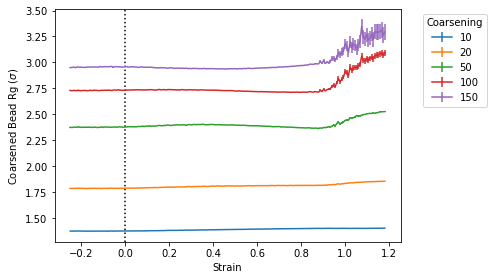

In [25]:
# n_arr = list(AllMeanRGDicts[0].keys())
# n_arr.remove('Width')
# n_arr.remove('stdWidth')
# fig, ax = plt.subplots(figsize=(7,4))

# colorind=0
# for i,n in enumerate(n_arr, start = 0):

#     curRGs = []
#     curRGSTDs = []
#     for index, curNum in enumerate(xAxisNums):
#         MeanRGDict = AllMeanRGDicts[index]
#         curRGs.append(MeanRGDict[n]['RG'])
#         curRGSTDs.append(MeanRGDict[n]['stdRG'])
        
#     ax.errorbar(x=xAxisNums, y=curRGs, yerr =curRGSTDs/np.sqrt(numReps), label = n, c = colors[colorind])
#     colorind+=1
        
# ax.set_xlabel(xlabel)
# ax.set_ylabel(r"Coarsened Bead Rg ($\sigma$)")
# ax.axvline(x=natNum, ls=':', color='black')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Coarsening')   

# fig.savefig('VisPlots/AllRg_'+jobName+'.pdf', dpi = 300, bbox_inches='tight')

# #plt.close(fig)

In [293]:
# fig, ax = plt.subplots()

# Widths = []
# WidthSTDs = []
# for index, dist in enumerate(dists):
#     MeanRGDict = AllMeanRGDicts[index]
#     Widths.append(MeanRGDict['Width'])
#     WidthSTDs.append(MeanRGDict['stdWidth'])

# Widths = np.array(Widths)
# ax.errorbar(x=strains, y=(Widths-Widths[np.argmin(np.abs(dists-natlen))])/Widths[np.argmin(np.abs(dists-natlen))], yerr = WidthSTDs/Widths[np.argmin(np.abs(dists-natlen))]/np.sqrt(numReps))
# ax.axvline(x=natNum, ls=':', color='black')
     
# ax.set_xlabel('Strain')
# ax.set_ylabel('Axial Strain')


# fig.savefig('VisPlots/Width_'+jobName+'.pdf', dpi = 300, bbox_inches='tight')

# #plt.close(fig)